# Réseau de neurones: les bases en numpy


Le but de ce TP1 est d'acquérir les bases nécessaires à la compréhension des réseaux de neurones à partir d'un modèle simple de type Softmax. La tâche d'apprentissage consiste à classifier les images (28 par 28 pixels) de la base MNIST (http://yann.lecun.com/exdb/mnist/) en 10 catégories représentant les chiffres 0-9.

Le TP2 consistera à généraliser les concepts de ce TP1 à un réseau de neurones multi-couches.

## Téléchargement de la base d'entraînement

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

mnistfile="C:/Users/MyPC/Documents/AIC-partage/Deep/TP/mnist.pkl.gz"

import pickle
import gzip
import numpy

# Load the dataset
with gzip.open('C:/Users/MyPC/Documents/AIC-partage/Deep/TP/mnist.pkl.gz', 'rb') as ifile:
    train_set, valid_set, test_set = pickle.load(ifile, encoding="latin-1")

## Chargement de la base en mémoire

Vous pouvez visualiser les différents caractères en changeant l'identifiant de l'image

label: 9


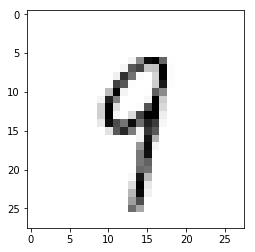

In [4]:
img_id = 900
plt.imshow(train_set[0][img_id].reshape(28,28),cmap='Greys')
print("label: " + str(train_set[1][img_id]))

**Question:** Donner les caractéristiques de la base d'apprentissage train_set

In [5]:
def getDimDataset(train_set):
    n_training = train_set[0].shape[0]
    n_feature = train_set[0].shape[1]
    n_label = len(np.unique(train_set[1]))
    return n_training, n_feature, n_label

In [6]:
getDimDataset(train_set)

(50000, 784, 10)

## Création du modèle

Nous allons d'abord créer une couche linéaire, soit une transformation linéaire. La vraie difficulté réside dans la manipulation de matrices de ne pas se mélanger dans les dimensions. 

Pour l'implémentation, nous allons considérer explicitement le terme de biais. Ainsi, une couche linéaire se définit comme la tranformation linéaire: 
$$
\mathbf{y} = \mathbf{W}\mathbf{x}+ \mathbf{b}
$$

Notons *n_in* et *n_out* respectivement les dimensions de $\mathbf{x}$ et $\mathbf{y}$. 

**Questions:**
- écrire les dimensions de W et b
- Coder la fonction d'init. suivante, l'init. est aléatoire et gaussienne, comme dans le cours. La fonction retourne W et b. 


In [7]:
def init1(n_in, n_out):
    W1 = np.random.normal(0, 1/np.sqrt(n_in), (n_out, n_in))
    b1 = np.random.normal(0, 1/np.sqrt(n_in), (n_out, 1))
    return W1, b1
   

def init(n_in,n_hidden, n_out):
    W1 = np.random.normal(0, 1/np.sqrt(n_in), (n_hidden, n_in))
    b1 = np.random.normal(0, 1/np.sqrt(n_in), (n_hidden, 1))
    W2 = np.random.normal(0, 1/np.sqrt(n_in), (n_out, n_hidden))
    b2 = np.random.normal(0, 1/np.sqrt(n_in), (n_out, 1))
    
    return W1,b1, W2,b2

**Test:** Même si cela ne sera pas redit, on vérifie toujours les dimensions de ce que l'on crée, et transforme. Dit autrement on fait des tests intermédiaires. En machine learning, comme en programmation, c'est incontournable. 
Pour cela créer, une couche de tailles d'entrée et de sortie égales à 5 et 3. 


In [8]:
W1,b1 = init1(5, 3)
print(W1)
print(b1)


[[-0.25259986 -0.5126613   0.35953631 -0.07140541 -0.3408528 ]
 [ 0.37519832 -0.11646337 -0.12555444  0.74125867 -0.03456818]
 [-0.14818082  0.165189    0.6548498   0.03110462  0.08666194]]
[[-0.53843461]
 [-0.02095832]
 [ 0.22669374]]


**Question :** Donner les dimensions de W et b ainsi que le nombre total de paramètres du modèle

In [9]:



def printInfo1(W1,b1):
    print("W1 dimensions: " + str(W1.shape))
    print("b1 dimensions: " + str(b1.shape))
    print("Number of parameters 1: " + str(np.size(W1) + np.size(b1)))
    
   


def printInfo(W1,b1, W2, b2):
    print("W1 dimensions: " + str(W1.shape))
    print("b1 dimensions: " + str(b1.shape))
    print("Number of parameters 1: " + str(np.size(W1) + np.size(b1)))
    
    print("W2 dimensions: " + str(W2.shape))
    print("b2 dimensions: " + str(b2.shape))
    print("Number of parameters 2: " + str(np.size(W2) + np.size(b2)))

In [10]:
printInfo1(W1, b1)

W1 dimensions: (3, 5)
b1 dimensions: (3, 1)
Number of parameters 1: 18


**Question:** Implémenter la fonction forward tel que $$y_j = \sum_{i \rightarrow j} W_{ij} x_i + b_j$$ où $x_i$ est un pixel de l'image, $W_{ij}$ est la valeur associée à l'arête reliant les unités $i$ et $j$ et $b_j$ est le biais associé à l'unité $j$

In [11]:
def forward(W,b,X):
    """
        Perform the forward propagation
        :param W: the weights (n_output x n_input)
        :param b: the bias (n_output * 1)
        :param X: the input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: the transformed values (n_output x minibatch_size)
        :rtype: ndarray
    """
    return np.dot(W, np.transpose(X)) + b

In [12]:
X = np.random.randn(4, 5)
forward(W1, b1, X)

array([[-0.27365545,  0.23684879, -0.53734615,  0.12405131],
       [-0.55301386,  0.38107911, -0.12418672, -0.53587193],
       [ 0.3549957 ,  0.49611971, -1.7987444 , -0.15882811]])

**Question:** Implémenter la fonction softmax $$ \sigma_i = \frac{\exp{a_i}}{\sum_k \exp{a_k}}$$

In [13]:
def softmax(a):
    """
        Perform the softmax transformation to the pre-activation values
        :param a: the pre-activation values (n_output x minibatch_size)
        :type a: ndarray
        :return: output the activation values (n_output x minibatch_size)
        :rtype: ndarray
    """
    a = a - np.max(a)
    output = a
    for i_sample in range(a.shape[1]):
        output[:, i_sample] = np.exp(a[:, i_sample]) / np.sum(np.exp(a[:, i_sample]))
    return output

**Question:** Vérifier que votre implémentation de softmax soit numériquement stable 

In [14]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
z = np.array(np.transpose([[1000000,1,100]]))
print(softmax(z))

[[1]
 [0]
 [0]]


In [17]:
def sigmoid(z):
    
    """
    Perform the sigmoid transformation to the pre-activation values
    :param z: the pre-activation values
    :type z: ndarray
    
    :return: y the activation values 
    :rtype:  ndarray
    :return: y_l derivative of the layer 
    :rtype:  ndarray
   
    
    """
        
    
    y = 1./(1.+np.exp(-z))
    y_deriv = np.multiply(y,(1-y))
    return y, y_deriv
    

In [18]:
np.zeros((5))

array([ 0.,  0.,  0.,  0.,  0.])

In [34]:

    
def forward3(W_list,b_list, X):
    
    
    """
    Step forward with the list of weight, we the stock the result into a list y_l,
    also we compute derivative associated with the step forward, it will be usefull for backward step,
    we stock derivative into a list y_l_grad
    :param W_list: list of weight 
    :type W_list: list of ndarray
    :param b_list: list of biais
    :type b_list: list of ndarray
    :param X: the input (minibatch_size x n_input)
    :type X: ndarray
    
    :return: a_l list of activations values 
    :rtype: liste of ndarray
    :return: y_l list of y_l  (sigmoid(activation values)), exept the last one who is not activated to use the softmax
    :rtype:  list ndarray
    :return: y_l_grad liste of gradient associated to step forward 
    :rtype: list ndarray ndarray
    
    """
    
    
    a_l=[]
    y_l = []
    y_l.append(X.transpose())
    y_l_grad =[]
    
    # One layer
    if len(W_list) == 1:
        a_last = forward(W_list[-1], b_list[-1], X)
        return a_last, y_l, y_l_grad, a_last
    
    #X = X.transpose() # rajout 
    # Several layers
    for i in range(len(W_list)-1):

        a_l.append(forward(W_list[i], b_list[i],X))
        #a = W_list[i].dot(X)+ b_list[i]
        #a_l.append(a)
        y_l.append(sigmoid(a_l[i])[0])
        y_l_grad.append(sigmoid(a_l[i])[1])
        X = sigmoid(forward(W_list[i], b_list[i],X))[0]
        X=X.transpose()
    a_last = forward(W_list[-1], b_list[-1], X)
    y_l.append(a_last)


    return a_l, y_l, y_l_grad, a_last



In [20]:
# grad_l le gradient de la sortie  renvoyer par grad_out
# ajout des gradient de loss selon a_l
def backward_al(grad_l, W_list,y_l_grad, y_l ):
    
    """
    Backward step, we compute here dLoss/da_l
    :param grad_l: gradient of Loss at the last layer, computed by the function gradient_out
    :type grad_l: ndarray
    :param W_list: list of weight 
    :type W_list: list of ndarray
    :param y_l_grad: list of gradient
    :type y_l_grad: list of ndarray
    
    :return: grad_a_lit , list of gradient dLoss/da_l 
    :rtype: liste of ndarray
    
    
    """
    grad_a_list= []
    
    #We only take the last gradient, if one layer 
    if len(W_list)==1:
        grad_a_list.append(grad_l)
        return grad_a_list
    
    
    grad_a_list.append(grad_l)
    
    for l in reversed(range(1, len(W_list))):
     
        grad_a= y_l_grad[l-1]* W_list[l].transpose().dot(grad_l)
        grad_a_list.append(grad_a)
        grad_l =grad_a
        
    #We inverse the list to be in the good sence
    
    grad_a_list= grad_a_list[::-1]
    return grad_a_list

def backward_w(grad_a_list, y_l, batch_size):
    
    
    """
    Backward step, we compute here dLoss/dw_l and dLoss/db_l with the gradient of dLoss/da_l computed by backward_al
    :param grad_a_list: gradient of loss dLoss/da_l
    :type grad_l: ndarray
    :param y_l: list of value of y_l  
    :type y_l: list of ndarray
    :param batch_size: size of the batch
    :type batch_size: int
    
    :return: grad_w_list , list of gradient dLoss/dw_l 
    :rtype: liste of ndarray
    :return: grad_b_list , list of gradient dLoss/db_l 
    :rtype: liste of ndarray
    
    
    """
      
    grad_w_list=[]
    grad_b_list=[]
    
    
    
    for k in range(0,len(grad_a_list)):
        
        grad_w= grad_a_list[k].dot(y_l[k].transpose())/ batch_size
        grad_b = np.sum(grad_a_list[k],axis=1).reshape(-1,1)/batch_size
        grad_w_list.append(grad_w)
        grad_b_list.append(grad_b)
        
    return grad_w_list, grad_b_list


        
        
        
                      

**Question:** Si le softmax s'avère instable, comment le rendre stable ? Proposer une implémentation stable du softmax. 

In [21]:
np.random.randn(3, 4)

array([[ 0.11280097,  0.75906261, -0.80060141,  1.07058229],
       [-0.62455717, -1.28760781, -1.17767695, -0.12010426],
       [-1.13931392, -0.04494575,  1.05682711, -0.66330914]])

**Question:** Implémenter le calcul du gradient de l'erreur par rapport à $a_i$:
$$\delta a_i = \sigma_i - 1_{i=l}$$
où $l$ est l'étiquette associée à la donnée courante.

In [21]:
def gradient_out(out, one_hot_batch):
    """
    compute the gradient w.r.t. the pre-activation values of the softmax z_i
    :param out: the softmax values (n_output x minibatch_size)
    :type out: ndarray
    :param one_hot_batch: the one-hot representation of the labels (n_output x minibatch_size)
    :type one_hot_batch: ndarray
    :return: the gradient w.r.t. z (n_output x minibatch_size)
    :rtype: ndarray
    """
    return out - one_hot_batch

**Question:** Implémenter la fonction du calcul de gradient par rapport aux paramètres: $$\delta W_{ij} = \delta a_j x_i$$  $$\delta b_{j} = \delta a_j$$ où $\delta W_{ij}$ est la composante du gradient associée à l'arête reliant les unités $i$ et $j$, $\delta b_{j}$ est la composante du gradient associée au bias de l'unité $j$, $\delta z_j$ est le gradient de l'erreur par rapport à l'unité $j$ et $x_i$ est la valeur d'activation de l'unité $i$.

**Question:** Implémenter la fonction de mise à jour des paramètres $$\theta = \theta - \eta \delta \theta$$ où $\theta$ est un paramètre du modèle et $\delta \theta$ la composante du gradient associée à $\theta$.

In [22]:
def update(eta, W_list, b_list, grad_w_list, grad_b_list):
    """
        Update the parameters with an update rule
        :param eta: the step-size
        :param W_list: list of the weights
        :param b_list: list the bias
        :param grad_w_list: list of the gradient w.r.t. the weights
        :param grad_b_list: list of the gradient w.r.t. the bias
        :type eta: float
        :type W_list: list of ndarray
        :type b_list: list of ndarray
        :type grad_w_list: list of ndarray
        :type grad_b_list: list of ndarray
        :return: the updated parameters
        :rtype: list of ndarray,  list of ndarray
    """
    
    for k in range(len(W_list)):
        W_list[k] = W_list[k] - eta * grad_w_list[k]
        b_list[k] = b_list[k] - eta * grad_b_list[k]
        
    return W_list, b_list

## Algorithme d'apprentissage 

On a tout ce qu'il faut pour mettre en oeuvre l'apprentissage d'un modèle simple. Le modèle est simplement une couche neuronale de sortie, sans couche cachée. 

L'algorithme se déroule en 2 temps, tout d'abord la préparation: 
- init. du modèle
- préparation des données et des variables permettant de stocker l'historique d'apprentissage
- init. des paramètres de la SGD
- définir le nombre d'époque comme une variable

Puis vient la boucle d'apprentissage qui pour chaque époque effectue pour chaque exemple d'apprentissage : 
- inférence du modèle sur l'exemple d'apprentissage 
- calcul de la contribution de l'exemple à la  fonction objectif, et également au taux d'erreur de classification
- Calcul du gradient de sortie
- Mise à jour du modèle

**Question:** Implémenter l'apprentissage du modèle

In [23]:
def one_hot_labels(labels, n_labels):
    """
    Compute one-hot representation of labels
    :param labels: labels of the samples (1 x minibatch_size)
    :param n_labels: number of different classes
    :type labels: ndarray
    :type n_labels: int
    :type minibatch_size: int
    :return: the one-hot representation (n_labels x minibatch_size)
    :rtype: ndarray
    """
    one_hot = np.zeros((n_labels, labels.size))
    one_hot[labels, np.arange(labels.size)] = 1
    return one_hot

def log_loss(outputs, one_hot_labels):
    """
    Compute log-loss of current batch
    :param outputs: outputs of the NNet (n_labels x minibatch_size)
    :param one_hot_labels: one-hot representation of real labels (n_labels x minibatch_size)
    :return log-loss summed over all outputs
    """
    return np.sum(-np.log(outputs) * one_hot_labels) / outputs.shape[1]


def error_rate(outputs, one_hot_labels):
    """
    Compute classification error rate of current batch
    :param outputs: outputs of the NNet (n_labels x minibatch_size)
    :param one_hot_labels: one-hot representation of real labels (n_labels x minibatch_size)
    :return error rate computed over all outputs
    """
    n_labels = one_hot_labels.shape[0]
    n_samples = one_hot_labels.shape[1]
    predicted_one_hot_labels = np.zeros(one_hot_labels.shape)
    predicted_one_hot_labels[np.argmax(outputs, axis=0), np.arange(n_samples)] = 1

    nb_correct_predictions = np.sum(predicted_one_hot_labels * one_hot_labels)
    return 1 - nb_correct_predictions / n_samples
    
    


In [24]:
def train_nnet(train_set,W_list, b_list, valid_set=[],  nb_epoch=3, minibatch_size=400, eta_0=1, eta_decrease_factor=0.2, n_hidden=300, print_=False):

    # initialisation of the NNet
    n_training, n_feature, n_label = getDimDataset(train_set)
   
    # datas to make graph of the learning etc. By batch
    iteration_counter = 0
    logloss_train = []
    error_train = []
    logloss_valid = []
    error_valid = []
    
    # datas to make graph of the learning etc. By epoch
    logloss_train_e = []
    error_train_e = []
    logloss_valid_e = []
    error_valid_e = []

    for i_epoch in range(nb_epoch):
        print("Training model (epoch = {}/{})".format(i_epoch+1, nb_epoch))
        for i_batch in range(0, n_training, minibatch_size):
            iteration_counter += 1
          
            # read the minibatch
            batches_index = np.arange(i_batch, i_batch + minibatch_size) % n_training
            X = train_set[0][batches_index, :]
            y = train_set[1][batches_index]

            # one-hot des labels
            y_one_hot = one_hot_labels(y, n_label)
            a_l, y_l, y_l_grad, a_last= forward3(W_list, b_list, X)
            
            
            # inference : forward propagation
            outputs = softmax(a_last)              #outputs = softmax(forward(W, b, X)
            
            # calcul de la log-loss et du taux d'erreur pour ce batch
            logloss_train.append(log_loss(outputs, y_one_hot))
            error_train.append(error_rate(outputs, y_one_hot))
            
            # print error train
            if(i_batch% minibatch_size*1000 ==0 and print_==True):
                print("erreur train ", error_rate(outputs, y_one_hot))

            # calcul de la log-loss et du taux d'erreur pour les samples de validation
            if valid_set:
                a_l_v, y_l_v, y_l_grad_v, a_last_v= forward3(W_list, b_list, valid_set[0])
                outputs_valid = softmax(a_last_v)
                labels_valid = one_hot_labels(valid_set[1], n_label)
                logloss_valid.append(log_loss(outputs_valid, labels_valid))
                error_valid.append(error_rate(outputs_valid, labels_valid))

            # calcul du gradient de sortie : backward propagation
            grad_z = gradient_out(outputs, y_one_hot)
           
            # calcul des gradients de Loss , dLoss/ dal  , dLoss/dwl, dLoss/dbl
            grad_a_list = backward_al(grad_z, W_list,y_l_grad, y_l )
            grad_w_list, grad_b_list =backward_w(grad_a_list, y_l, minibatch_size)
            

            # mise a jour du modele
            eta = eta_0 / (1 + eta_decrease_factor * iteration_counter)
            W_list, b_list = update(eta, W_list, b_list, grad_w_list, grad_b_list)
            
        
        #Compute Loss for all the train
        X = train_set[0]
        y = train_set[1]
        
        # one-hot des labels
        y_one_hot = one_hot_labels(y, n_label)
        a_l, y_l, y_l_grad, a_last= forward3(W_list, b_list, X)
            
            
        # compute the predictions output
        outputs = softmax(a_last)              #outputs = softmax(forward(W, b, X)
            
        # log loss for all train and valid 
        logloss_train_e.append(log_loss(outputs, y_one_hot))
        error_train_e.append(error_rate(outputs, y_one_hot))
        logloss_valid_e.append(log_loss(outputs_valid, labels_valid))
        error_valid_e.append(error_rate(outputs_valid, labels_valid))
            
        

      
        
        
   
        
        
        
    return W_list, b_list, logloss_train, error_train, logloss_valid, error_valid, logloss_train_e, error_train_e, logloss_valid_e, error_valid_e


In [76]:
#TP1 ONE LAYER

# Parameters
NB_EPOCH = 10
MINIBATCH_SIZE = 400
ETA_0 = 1
DECREASE_CONSTANT = 0

# initialisation of the NNet
n_training, n_feature, n_label = getDimDataset(train_set)

#initialisation of weigth and bias
W1, b1 = init1(n_feature, n_label)
print("W1 " ,W1.shape)
    
W_list =[W1]
b_list =[b1]




W, b, logloss_train, error_train, logloss_valid, error_valid, logloss_train_e, error_train_e, logloss_valid_e, error_valid_e = train_nnet(train_set, W_list, b_list, valid_set,  NB_EPOCH, MINIBATCH_SIZE, ETA_0, DECREASE_CONSTANT, N_HIDDEN)

W1  (10, 784)
Training model (epoch = 1/10)
Training model (epoch = 2/10)
Training model (epoch = 3/10)
Training model (epoch = 4/10)
Training model (epoch = 5/10)
Training model (epoch = 6/10)
Training model (epoch = 7/10)
Training model (epoch = 8/10)
Training model (epoch = 9/10)
Training model (epoch = 10/10)


**Question:** Si vous stockez correctement les informations, vous pouvez tracer l'évolution du taux d'erreur et de la fonction objectif au cours du temps. Cette étape est loin d'être illustrative, elle est indispensable pour vérifier si l'apprentissage se passe bien. 



**Question:** Inclure dans votre code, le calcul du taux d'erreur et de la fonction objectif sur les données de validation (cela doit faire l'objet du fonction à part). Représenter les évolutions également et les comparer avec celles observées sur les données d'apprentissage. 

Results for test set :
 - mean log-loss for each sample = 0.282
 - classification error rate     = 8.05%


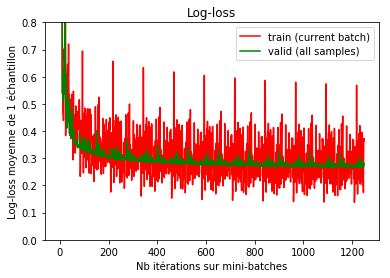

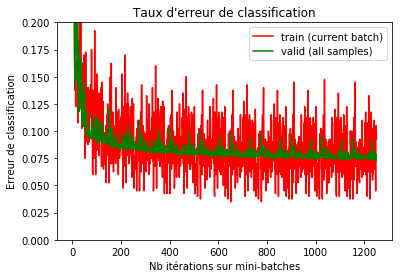

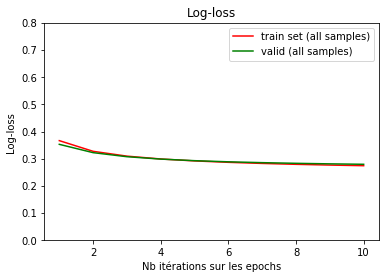

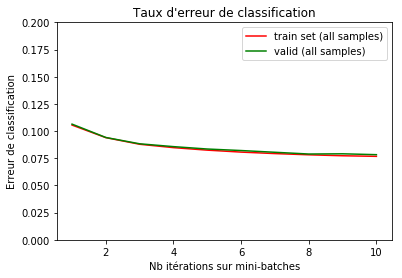

In [77]:
outputs_test = softmax(forward3(W, b, test_set[0])[-1] )
labels_test = one_hot_labels(test_set[1], 10)
print("Results for test set :")
print(" - mean log-loss for each sample = {:.3f}".format(log_loss(outputs_test, labels_test)))
print(" - classification error rate     = {:.2f}%".format(error_rate(outputs_test, labels_test) * 100))

plt.plot(logloss_train, "r", label='train (current batch)')
plt.plot(logloss_valid, "g", label='valid (all samples)')
plt.title("Log-loss")
plt.xlabel("Nb itérations sur mini-batches")
plt.ylabel("Log-loss on batch")
plt.legend()
plt.ylim((0, 0.8))
plt.show()

plt.plot(error_train, "r", label='train (current batch)')
plt.plot(error_valid, "g", label='valid (all samples)')
plt.title("Rate error classification")
plt.xlabel("iterations on batch")
plt.ylabel("Rate classification error")
plt.legend()
plt.ylim((0, 0.2))
plt.show()


index = list(range(1,NB_EPOCH+1))
plt.plot(index , logloss_train_e, "r", label='train set (all samples)')
plt.plot(index ,logloss_valid_e, "g", label='valid (all samples)')
plt.title("Log-loss")
plt.xlabel("epochs")
plt.ylabel("Log-loss ")
plt.legend()
plt.ylim((0, 0.8))
plt.show()




plt.plot(index, error_train_e, "r", label='train set (all samples)')
plt.plot(index, error_valid_e, "g", label='valid (all samples)')
plt.title("Rate classification error")
plt.xlabel("epochs")
plt.ylabel("Rate classification error")
plt.legend()
plt.ylim((0, 0.2))
plt.show()

**Question:** Montrer, à l'aide d'une figure, l'effet du step-size (prendre $\eta$=[0.01,0.1,1.0,10.]) sur les courbes d'apprentissage

Learning for eta = 0.01
Training model (epoch = 1/3)
Training model (epoch = 2/3)
Training model (epoch = 3/3)
Learning for eta = 0.1
Training model (epoch = 1/3)
Training model (epoch = 2/3)
Training model (epoch = 3/3)
Learning for eta = 1.0
Training model (epoch = 1/3)
Training model (epoch = 2/3)
Training model (epoch = 3/3)
Learning for eta = 10.0
Training model (epoch = 1/3)
Training model (epoch = 2/3)
Training model (epoch = 3/3)


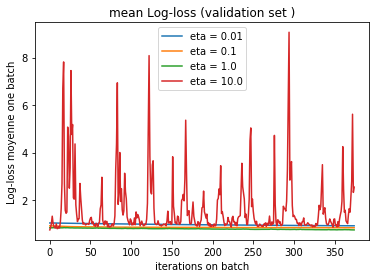

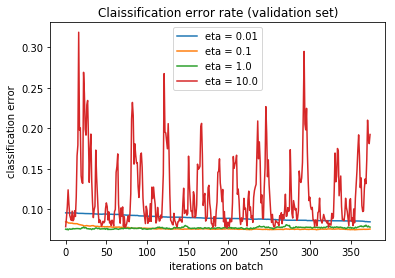

In [87]:
NB_EPOCH = 3
MINIBATCH_SIZE = 400
TRAIN = True

eta_range =[0.01, 0.1, 1.0, 10.0]

# train
if TRAIN:
    # batch
    log_loss_train = []
    error_rate_train = []
    log_loss_valid = []
    error_rate_valid = []
    
    # epoch
    log_loss_train_e = []
    error_rate_train_e = []
    log_loss_valid_e = []
    error_rate_valid_e = []
    
    for eta in eta_range:
        print("Learning for eta = {}".format(eta))
        W, b, logloss_train, error_train, logloss_valid, error_valid, logloss_train_e, error_train_e, logloss_valid_e, error_valid_e = train_nnet(train_set, W_list, b_list, valid_set,  NB_EPOCH, MINIBATCH_SIZE, eta, 0, N_HIDDEN)
        #_, _, logloss_train, error_train, logloss_valid, error_valid = train_nnet(train_set, valid_set, NB_EPOCH, MINIBATCH_SIZE, eta, 0)
        log_loss_train.append(logloss_train)
        error_rate_train.append(error_train)
        log_loss_valid.append(logloss_valid)
        error_rate_valid.append(error_valid)
        
        log_loss_train_e.append(logloss_train_e)
        error_rate_train_e.append(error_train_e)
        log_loss_valid_e.append(logloss_valid_e)
        error_rate_valid_e.append(error_valid_e)

# display results
for i in range(len(log_loss_valid)):
    plt.plot(log_loss_valid[i], label="eta = " + str(eta_range[i]))
plt.title("mean Log-loss (validation set )")
plt.xlabel("iterations on batch")
plt.ylabel("Log-loss moyenne one batch")
plt.legend()
plt.show()

for i in range(len(log_loss_valid)):
    plt.plot(error_rate_valid[i], label="eta = " + str(eta_range[i]))
plt.title("Claissification error rate (validation set)")
plt.xlabel("iterations on batch ")
plt.ylabel("classification error")
plt.legend()
plt.show()

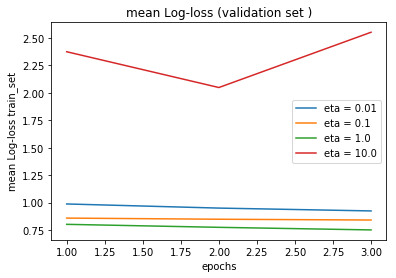

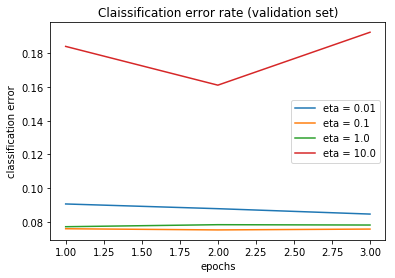

In [88]:
# display results
index = list(range(1,NB_EPOCH+1))
for i in range(len(log_loss_valid_e)):
    plt.plot(index, log_loss_valid_e[i], label="eta = " + str(eta_range[i]))
    
plt.title("mean Log-loss (validation set )")
plt.xlabel("epochs")
plt.ylabel("mean Log-loss train_set")
plt.legend()
plt.show()

for i in range(len(log_loss_valid_e)):
    
    plt.plot(index, error_rate_valid_e[i], label="eta = " + str(eta_range[i]))
    
plt.title(("Claissification error rate (validation set)"))
plt.xlabel("epochs")
plt.ylabel("classification error")
plt.legend()
plt.show()



In [89]:
#TP2 TWO LAYER

# Parameters
NB_EPOCH = 10
MINIBATCH_SIZE = 400
ETA_0 = 1
DECREASE_CONSTANT = 0
N_HIDDEN = 300

# initialisation of the NNet
n_training, n_feature, n_label = getDimDataset(train_set)

#initialisation of weigth and bias
W1, b1, W2, b2 = init(n_feature,N_HIDDEN,  n_label)

    
W_list =[W1, W2]
b_list =[b1, b2]




W, b, logloss_train, error_train, logloss_valid, error_valid, logloss_train_e, error_train_e, logloss_valid_e, error_valid_e = train_nnet(train_set, W_list, b_list, valid_set,  NB_EPOCH, MINIBATCH_SIZE, ETA_0, DECREASE_CONSTANT, N_HIDDEN)

Training model (epoch = 1/10)
Training model (epoch = 2/10)
Training model (epoch = 3/10)
Training model (epoch = 4/10)
Training model (epoch = 5/10)
Training model (epoch = 6/10)
Training model (epoch = 7/10)
Training model (epoch = 8/10)
Training model (epoch = 9/10)
Training model (epoch = 10/10)


Results for test set :
 - mean log-loss for each sample = 0.167
 - classification error rate     = 4.87%


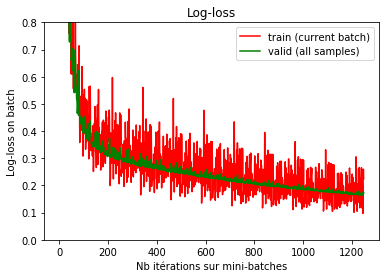

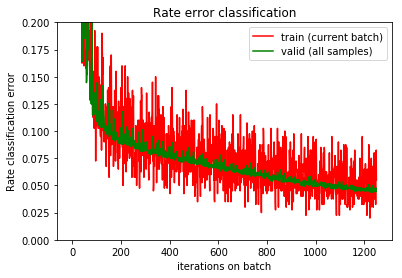

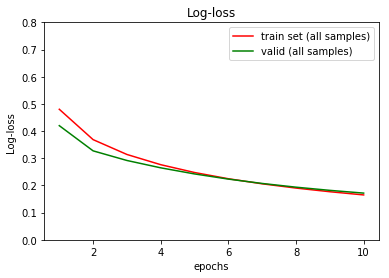

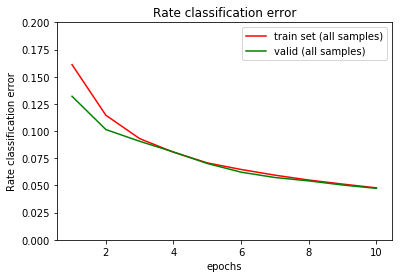

In [90]:
outputs_test = softmax(forward3(W, b, test_set[0])[-1] )
labels_test = one_hot_labels(test_set[1], 10)
print("Results for test set :")
print(" - mean log-loss for each sample = {:.3f}".format(log_loss(outputs_test, labels_test)))
print(" - classification error rate     = {:.2f}%".format(error_rate(outputs_test, labels_test) * 100))

plt.plot(logloss_train, "r", label='train (current batch)')
plt.plot(logloss_valid, "g", label='valid (all samples)')
plt.title("Log-loss")
plt.xlabel("Nb itérations sur mini-batches")
plt.ylabel("Log-loss on batch")
plt.legend()
plt.ylim((0, 0.8))
plt.show()

plt.plot(error_train, "r", label='train (current batch)')
plt.plot(error_valid, "g", label='valid (all samples)')
plt.title("Rate error classification")
plt.xlabel("iterations on batch")
plt.ylabel("Rate classification error")
plt.legend()
plt.ylim((0, 0.2))
plt.show()


index = list(range(1,NB_EPOCH+1))
plt.plot(index , logloss_train_e, "r", label='train set (all samples)')
plt.plot(index ,logloss_valid_e, "g", label='valid (all samples)')
plt.title("Log-loss")
plt.xlabel("epochs")
plt.ylabel("Log-loss ")
plt.legend()
plt.ylim((0, 0.8))
plt.show()




plt.plot(index, error_train_e, "r", label='train set (all samples)')
plt.plot(index, error_valid_e, "g", label='valid (all samples)')
plt.title("Rate classification error")
plt.xlabel("epochs")
plt.ylabel("Rate classification error")
plt.legend()
plt.ylim((0, 0.2))
plt.show()

In [26]:
# Several layers with n_hidden neurones in each layer 
def automatic_init(n_in,n_hidden, n_out, n_layer):
    
    W1 = np.random.normal(0, 1/np.sqrt(n_in), (n_hidden, n_in))
    b1 = np.random.normal(0, 1/np.sqrt(n_in), (n_hidden, 1))
    W_list=[]
    b_list=[]
    W_list.append(W1)
    b_list.append(b1)
    
    if n_layer ==1:
        return W_list, b_list
    
    
    for i in range(n_layer-2):
        W = np.random.normal(0, 1/np.sqrt(n_in), (n_hidden, n_hidden))
        b = np.random.normal(0, 1/np.sqrt(n_in), (n_hidden, 1))
        
        W_list.append(W)
        b_list.append(b)
        
    W_last = np.random.normal(0, 1/np.sqrt(n_in), (n_out, n_hidden))
    b_last = np.random.normal(0, 1/np.sqrt(n_in), (n_out, 1))
    W_list.append(W_last)
    b_list.append(b_last)
    
    return W_list, b_list
    

In [37]:
#BONUS THREEE LAYER

# Parameters
NB_EPOCH = 10
MINIBATCH_SIZE = 400
ETA_0 = 1
DECREASE_CONSTANT = 0
N_HIDDEN = 300
N_LAYER=3

# initialisation of the NNet
n_training, n_feature, n_label = getDimDataset(train_set)

#initialisation of weigth and bias
W_list, b_list = automatic_init(n_feature,N_HIDDEN,  n_label, N_LAYER)

for w in W_list:
    print(w.shape)
    





W, b, logloss_train, error_train, logloss_valid, error_valid, logloss_train_e, error_train_e, logloss_valid_e, error_valid_e = train_nnet(train_set, W_list, b_list, valid_set,  NB_EPOCH, MINIBATCH_SIZE, ETA_0, DECREASE_CONSTANT, N_HIDDEN)

(300, 784)
(300, 300)
(10, 300)
Training model (epoch = 1/10)
Training model (epoch = 2/10)
Training model (epoch = 3/10)
Training model (epoch = 4/10)
Training model (epoch = 5/10)
Training model (epoch = 6/10)
Training model (epoch = 7/10)
Training model (epoch = 8/10)
Training model (epoch = 9/10)
Training model (epoch = 10/10)


Results for test set :
 - mean log-loss for each sample = 0.232
 - classification error rate     = 7.12%


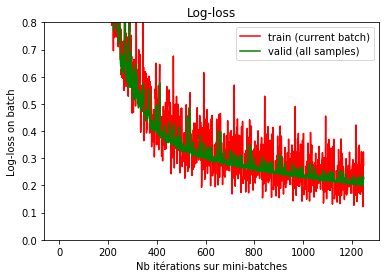

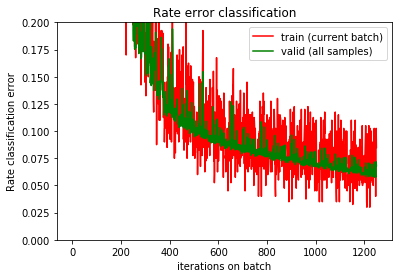

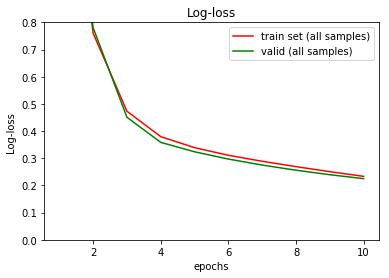

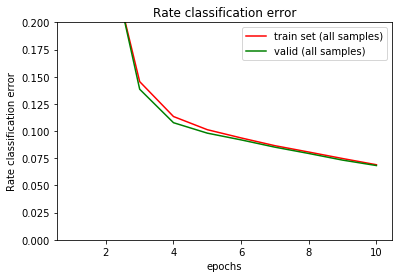

In [38]:
outputs_test = softmax(forward3(W, b, test_set[0])[-1] )
labels_test = one_hot_labels(test_set[1], 10)
print("Results for test set :")
print(" - mean log-loss for each sample = {:.3f}".format(log_loss(outputs_test, labels_test)))
print(" - classification error rate     = {:.2f}%".format(error_rate(outputs_test, labels_test) * 100))

plt.plot(logloss_train, "r", label='train (current batch)')
plt.plot(logloss_valid, "g", label='valid (all samples)')
plt.title("Log-loss")
plt.xlabel("Nb itérations sur mini-batches")
plt.ylabel("Log-loss on batch")
plt.legend()
plt.ylim((0, 0.8))
plt.show()

plt.plot(error_train, "r", label='train (current batch)')
plt.plot(error_valid, "g", label='valid (all samples)')
plt.title("Rate error classification")
plt.xlabel("iterations on batch")
plt.ylabel("Rate classification error")
plt.legend()
plt.ylim((0, 0.2))
plt.show()


index = list(range(1,NB_EPOCH+1))
plt.plot(index , logloss_train_e, "r", label='train set (all samples)')
plt.plot(index ,logloss_valid_e, "g", label='valid (all samples)')
plt.title("Log-loss")
plt.xlabel("epochs")
plt.ylabel("Log-loss ")
plt.legend()
plt.ylim((0, 0.8))
plt.show()




plt.plot(index, error_train_e, "r", label='train set (all samples)')
plt.plot(index, error_valid_e, "g", label='valid (all samples)')
plt.title("Rate classification error")
plt.xlabel("epochs")
plt.ylabel("Rate classification error")
plt.legend()
plt.ylim((0, 0.2))
plt.show()